
# Homework Description
- English to Chinese (Traditional) Translation
把英语翻译成繁体中文
  - Input: an English sentence         (e.g.        tom is a student .)
  - Output: the Chinese translation  (e.g.      湯姆 是 個 學生 。)
​
- TODO
    - Train a simple RNN seq2seq to acheive translation
    训练一个简单的RNN seq2seq模型去实现翻译
    - Switch to transformer model to boost performance
    把RNN改成transformer模型去得到更高的分数
    - Apply Back-translation to furthur boost performance
    使用Back-translation去进一步提高
    分数
    

# Download and import required packages
# 下载并import一堆库

In [204]:
!nvidia-smi

Sun May  7 05:03:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    34W / 250W |   4521MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [205]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets
!pip install --upgrade jupyter

In [206]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

fatal: destination path 'fairseq' already exists and is not an empty directory.
HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+9a1c497-cp37-cp37m-linux_x86_64.whl size=2039062 sha256=6fef4eadf73cb92a1fd5c47b32f5d8ceeea181cc099d170499377cc67a39d947
  Stored in directory: /tmp/pip-ephem-wheel-cache-5hrbz_10/wheels/c8/ca/fd/f57b5450f90d8ce5f5b0bca2d8533572e2be617a079c9b2718
Successfully built fairseq
  Attempting uninstall: fairseq
    Found existing installation: fairseq 1.0.0a0+9a1c497
    Uninstalling fairseq-1.0.0a0+9a1c497:
      Successfully uninstalled fairseq-1.0.0a0+9a1c497


In [207]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
#import tqdm.auto as tqdm
from tqdm import tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed
# 固定随机数种子

In [208]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [209]:
#下载并解压文件

data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name
#absolute()返回绝对路径 

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
!rm -rf {prefix/'test'}

raw.en
raw.zh
test/
test/test.zh
test/test.en


## Language

In [210]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [211]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files
## 预处理

In [212]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    #把全角符号变成半角符号
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            # ord函数，返回某字符的ASCLL码或Unicode数值
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32  #直接把全角空格变成半角空格
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248  #改变其他全角符号
            rstring += chr(inside_code)
            # chr函数，ord的逆操作，输入某一数值返回对应的字符
        ss.append(rstring)
    return ''.join(ss)
                
#数据清洗，去除一堆字符
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text]) 正则表达式操作
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())


#清洗语料库，看不懂
#似乎是删去过长或者过短的句子？
def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [213]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/kaggle/working/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/kaggle/working/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [214]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid
## 把数据分成训练集和验证集

In [215]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [216]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

#就是使用词缀来分隔并表示单词，避免遇到OOV（模型里没有的单词）
参见https://zhuanlan.zhihu.com/p/112444056

In [217]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/kaggle/working/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [218]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/kaggle/working/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/kaggle/working/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/kaggle/working/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/kaggle/working/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/kaggle/working/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/kaggle/working/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [219]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

## 使用fairseq工具对数据进行处理

In [220]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments
# 超参数设置

In [221]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    # 在数据获取和处理时使用的CPU线程数
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=40,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

# 输出日志

In [222]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [223]:
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler = logging.FileHandler('my.log')
fhandler.setLevel(logging.DEBUG)
fhandler.setFormatter(formatter)

chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)
chandler.setFormatter(formatter)

logger.addHandler(fhandler)
logger.addHandler(chandler)
logger.setLevel(logging.DEBUG)

logger.handlers

[<FileHandler /kaggle/working/my.log (DEBUG)>,
 <StreamHandler stderr (DEBUG)>,
 <FileHandler /kaggle/working/my.log (DEBUG)>,
 <StreamHandler stderr (DEBUG)>,
 <FileHandler /kaggle/working/my.log (DEBUG)>,
 <StreamHandler stderr (DEBUG)>,
 <FileHandler /kaggle/working/my.log (DEBUG)>,
 <StreamHandler stderr (DEBUG)>]

# CUDA Environments

In [224]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [225]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

In [226]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-05-07 05:04:09,657 - hw5.seq2seq - INFO - loading data for epoch 1
2023-05-07 05:04:09,657 - hw5.seq2seq - INFO - loading data for epoch 1
2023-05-07 05:04:09,657 - hw5.seq2seq - INFO - loading data for epoch 1
2023-05-07 05:04:09,657 - hw5.seq2seq - INFO - loading data for epoch 1


In [227]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [228]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

{'id': tensor([723]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]]),
  'src_lengths': tensor([19]),
  'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
构建模型
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.
*这里又直接用了fairseq的encoder, decoder 和 model

In [229]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

from fairseq.models.transformer import (
    TransformerEncoder,
    TransformerDecoder

)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
-Encoder是RNN或者Transformer里的Encoder。 RNN就是每次输入一个向量然后产生一个输出向量和一个隐藏层向量。隐藏层向量输入到下一步中参与运算。然后RNN依次读句子，最后输出一个向量。
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      -控制embedding的维数
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      -控制hidden states and output vectors的维数
      - encoder_layers is the number of layers for Encoder 
      -RNN层数
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [230]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [231]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [232]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [233]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [234]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    # encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [235]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    #使用transformer后，这里要改成4层,原本为1层
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    #使用transformer后，这里要改成4层,原本为1层
    share_decoder_input_output_embed=True,
    dropout=0.16,
    #原本为0.3
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

# add_transformer_args(arch_args)

In [236]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [237]:
model = build_model(arch_args, task)
logger.info(model)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2023-05-07 05:04:10,143 - hw5.seq2seq - INFO - Seq2Seq(
  (encoder): RNNEncoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.16, inplace=False)
    (rnn): GRU(256, 512, dropout=0.16, bidirectional=True)
    (dropout_out_module): Dropout(p=0.16, inplace=False)
  )
  (decoder): RNNDecoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.16, inplace=False)
    (rnn): GRU(256, 1024, dropout=0.16)
    (attention): AttentionLayer(
      (input_proj): Linear(in_features=256, out_features=1024, bias=False)
      (output_proj): Linear(in_features=1280, out_features=256, bias=False)
    )
    (dropout_out_module): Dropout(p=

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [238]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [239]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    #lr = 0.001
    lr = (d_model ** -0.5) * min(step_num ** -0.5 , step_num * warmup_step**-1.5)
    #动态改变学习率，使用上面老师给的公式
    return lr

In [240]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

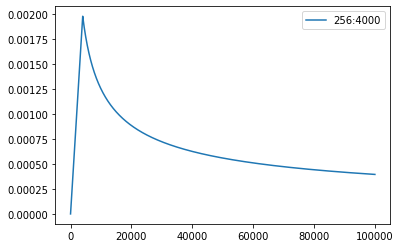

In [241]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [242]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    #progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=True)
    progress = tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=True)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [243]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [244]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    #progress = tqdm.tqdm(itr, desc=f"validation", leave=True)
    progress = tqdm(itr, desc=f"validation", leave=True)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [245]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [246]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [247]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2023-05-07 05:04:10,694 - hw5.seq2seq - INFO - task: TranslationTask
2023-05-07 05:04:10,694 - hw5.seq2seq - INFO - task: TranslationTask
2023-05-07 05:04:10,694 - hw5.seq2seq - INFO - task: TranslationTask
2023-05-07 05:04:10,694 - hw5.seq2seq - INFO - task: TranslationTask
2023-05-07 05:04:10,699 - hw5.seq2seq - INFO - encoder: RNNEncoder
2023-05-07 05:04:10,699 - hw5.seq2seq - INFO - encoder: RNNEncoder
2023-05-07 05:04:10,699 - hw5.seq2seq - INFO - encoder: RNNEncoder
2023-05-07 05:04:10,699 - hw5.seq2seq - INFO - encoder: RNNEncoder
2023-05-07 05:04:10,703 - hw5.seq2seq - INFO - decoder: RNNDecoder
2023-05-07 05:04:10,703 - hw5.seq2seq - INFO - decoder: RNNDecoder
2023-05-07 05:04:10,703 - hw5.seq2seq - INFO - decoder: RNNDecoder
2023-05-07 05:04:10,703 - hw5.seq2seq - INFO - decoder: RNNDecoder
2023-05-07 05:04:10,707 - hw5.seq2seq - INFO - criterion: LabelSmoothedCrossEntropyCriterion
2023-05-07 05:04:10,707 - hw5.seq2seq - INFO - criterion: LabelSmoothedCrossEntropyCriterion
20

In [248]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
epoch_num=0
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    epoch_num+=1
    print(epoch_num)
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2023-05-07 05:04:10,838 - hw5.seq2seq - INFO - loaded checkpoint checkpoints/rnn/checkpoint_last.pt: step=3891 loss=4.286708831787109 bleu=12.72500347921248
2023-05-07 05:04:10,838 - hw5.seq2seq - INFO - loaded checkpoint checkpoints/rnn/checkpoint_last.pt: step=3891 loss=4.286708831787109 bleu=12.72500347921248
2023-05-07 05:04:10,838 - hw5.seq2seq - INFO - loaded checkpoint checkpoints/rnn/checkpoint_last.pt: step=3891 loss=4.286708831787109 bleu=12.72500347921248
2023-05-07 05:04:10,838 - hw5.seq2seq - INFO - loaded checkpoint checkpoints/rnn/checkpoint_last.pt: step=3891 loss=4.286708831787109 bleu=12.72500347921248


1


train epoch 1:  68%|██████▊   | 539/791 [01:56<00:57,  4.35it/s, loss=4.19]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x731eac364320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
train epoch 1:  68%|██████▊   | 540/791 [01:57<01:14,  3.35it/s, loss=4.54]can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x731eac364320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/co

2


train epoch 2: 100%|██████████| 791/791 [02:52<00:00,  4.60it/s, loss=3.89]
2023-05-07 05:10:14,436 - hw5.seq2seq - INFO - training loss: 4.2403
2023-05-07 05:10:14,436 - hw5.seq2seq - INFO - training loss: 4.2403
2023-05-07 05:10:14,436 - hw5.seq2seq - INFO - training loss: 4.2403
2023-05-07 05:10:14,436 - hw5.seq2seq - INFO - training loss: 4.2403
2023-05-07 05:10:14,440 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:10:14,440 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:10:14,440 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:10:14,440 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:15<00:00,  1.38it/s, valid_loss=4.78]
2023-05-07 05:10:31,808 - hw5.seq2seq - INFO - example source: we can push through that .
2023-05-07 05:10:31,808 - hw5.seq2seq - INFO - example source: we can push through that .
2023-05-07 05:10:31,808 - hw5.seq2seq - INFO - example source: we can push through that .
2023-05-07 05:10:31,808 - hw5.seq2seq - INFO 

3


train epoch 3: 100%|██████████| 791/791 [02:53<00:00,  4.57it/s, loss=4.2] 
2023-05-07 05:13:25,314 - hw5.seq2seq - INFO - training loss: 4.1969
2023-05-07 05:13:25,314 - hw5.seq2seq - INFO - training loss: 4.1969
2023-05-07 05:13:25,314 - hw5.seq2seq - INFO - training loss: 4.1969
2023-05-07 05:13:25,314 - hw5.seq2seq - INFO - training loss: 4.1969
2023-05-07 05:13:25,319 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:13:25,319 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:13:25,319 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:13:25,319 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s, valid_loss=4.72]
2023-05-07 05:13:43,717 - hw5.seq2seq - INFO - example source: thank you .
2023-05-07 05:13:43,717 - hw5.seq2seq - INFO - example source: thank you .
2023-05-07 05:13:43,717 - hw5.seq2seq - INFO - example source: thank you .
2023-05-07 05:13:43,717 - hw5.seq2seq - INFO - example source: thank you .
2023-05-07 05:1

4


train epoch 4: 100%|██████████| 791/791 [02:52<00:00,  4.58it/s, loss=4.15]
2023-05-07 05:16:36,627 - hw5.seq2seq - INFO - training loss: 4.1368
2023-05-07 05:16:36,627 - hw5.seq2seq - INFO - training loss: 4.1368
2023-05-07 05:16:36,627 - hw5.seq2seq - INFO - training loss: 4.1368
2023-05-07 05:16:36,627 - hw5.seq2seq - INFO - training loss: 4.1368
2023-05-07 05:16:36,632 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:16:36,632 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:16:36,632 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:16:36,632 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s, valid_loss=4.78]
2023-05-07 05:16:55,826 - hw5.seq2seq - INFO - example source: those men would eventually be convicted of placing a van filled with 1 , 500 pounds of explosives into the sublevel parking lot of the world trade center's north tower , causing an explosion that killed six people and injured over 1 , 000 others .
2023

5


train epoch 5: 100%|██████████| 791/791 [02:52<00:00,  4.60it/s, loss=4.1] 
2023-05-07 05:19:48,079 - hw5.seq2seq - INFO - training loss: 4.0862
2023-05-07 05:19:48,079 - hw5.seq2seq - INFO - training loss: 4.0862
2023-05-07 05:19:48,079 - hw5.seq2seq - INFO - training loss: 4.0862
2023-05-07 05:19:48,079 - hw5.seq2seq - INFO - training loss: 4.0862
2023-05-07 05:19:48,083 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:19:48,083 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:19:48,083 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:19:48,083 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s, valid_loss=4.77]
2023-05-07 05:20:06,372 - hw5.seq2seq - INFO - example source: but this is really how i go about creating these photographs .
2023-05-07 05:20:06,372 - hw5.seq2seq - INFO - example source: but this is really how i go about creating these photographs .
2023-05-07 05:20:06,372 - hw5.seq2seq - INFO - example source: 

6


train epoch 6: 100%|██████████| 791/791 [02:53<00:00,  4.57it/s, loss=3.75]
2023-05-07 05:22:59,812 - hw5.seq2seq - INFO - training loss: 4.0475
2023-05-07 05:22:59,812 - hw5.seq2seq - INFO - training loss: 4.0475
2023-05-07 05:22:59,812 - hw5.seq2seq - INFO - training loss: 4.0475
2023-05-07 05:22:59,812 - hw5.seq2seq - INFO - training loss: 4.0475
2023-05-07 05:22:59,817 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:22:59,817 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:22:59,817 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:22:59,817 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s, valid_loss=4.76]
2023-05-07 05:23:18,347 - hw5.seq2seq - INFO - example source: so that is a fact .
2023-05-07 05:23:18,347 - hw5.seq2seq - INFO - example source: so that is a fact .
2023-05-07 05:23:18,347 - hw5.seq2seq - INFO - example source: so that is a fact .
2023-05-07 05:23:18,347 - hw5.seq2seq - INFO - example source: so 

7


train epoch 7: 100%|██████████| 791/791 [02:53<00:00,  4.57it/s, loss=4.17]
2023-05-07 05:26:11,869 - hw5.seq2seq - INFO - training loss: 4.0153
2023-05-07 05:26:11,869 - hw5.seq2seq - INFO - training loss: 4.0153
2023-05-07 05:26:11,869 - hw5.seq2seq - INFO - training loss: 4.0153
2023-05-07 05:26:11,869 - hw5.seq2seq - INFO - training loss: 4.0153
2023-05-07 05:26:11,873 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:26:11,873 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:26:11,873 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:26:11,873 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s, valid_loss=4.77]
2023-05-07 05:26:30,246 - hw5.seq2seq - INFO - example source: thank you so much everyone .
2023-05-07 05:26:30,246 - hw5.seq2seq - INFO - example source: thank you so much everyone .
2023-05-07 05:26:30,246 - hw5.seq2seq - INFO - example source: thank you so much everyone .
2023-05-07 05:26:30,246 - hw5.seq2seq -

8


train epoch 8: 100%|██████████| 791/791 [02:52<00:00,  4.58it/s, loss=4.08]
2023-05-07 05:29:23,285 - hw5.seq2seq - INFO - training loss: 3.9872
2023-05-07 05:29:23,285 - hw5.seq2seq - INFO - training loss: 3.9872
2023-05-07 05:29:23,285 - hw5.seq2seq - INFO - training loss: 3.9872
2023-05-07 05:29:23,285 - hw5.seq2seq - INFO - training loss: 3.9872
2023-05-07 05:29:23,289 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:29:23,289 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:29:23,289 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:29:23,289 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s, valid_loss=4.78]
2023-05-07 05:29:42,000 - hw5.seq2seq - INFO - example source: these differences became a source of inspired artistic celebration .
2023-05-07 05:29:42,000 - hw5.seq2seq - INFO - example source: these differences became a source of inspired artistic celebration .
2023-05-07 05:29:42,000 - hw5.seq2seq - INFO - exam

9


train epoch 9: 100%|██████████| 791/791 [02:52<00:00,  4.59it/s, loss=3.51]
2023-05-07 05:32:34,794 - hw5.seq2seq - INFO - training loss: 3.9613
2023-05-07 05:32:34,794 - hw5.seq2seq - INFO - training loss: 3.9613
2023-05-07 05:32:34,794 - hw5.seq2seq - INFO - training loss: 3.9613
2023-05-07 05:32:34,794 - hw5.seq2seq - INFO - training loss: 3.9613
2023-05-07 05:32:34,798 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:32:34,798 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:32:34,798 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:32:34,798 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.30it/s, valid_loss=4.75]
2023-05-07 05:32:53,313 - hw5.seq2seq - INFO - example source: it's not .
2023-05-07 05:32:53,313 - hw5.seq2seq - INFO - example source: it's not .
2023-05-07 05:32:53,313 - hw5.seq2seq - INFO - example source: it's not .
2023-05-07 05:32:53,313 - hw5.seq2seq - INFO - example source: it's not .
2023-05-07 05:32:53

10


train epoch 10: 100%|██████████| 791/791 [02:52<00:00,  4.57it/s, loss=3.67]
2023-05-07 05:35:46,617 - hw5.seq2seq - INFO - training loss: 3.9389
2023-05-07 05:35:46,617 - hw5.seq2seq - INFO - training loss: 3.9389
2023-05-07 05:35:46,617 - hw5.seq2seq - INFO - training loss: 3.9389
2023-05-07 05:35:46,617 - hw5.seq2seq - INFO - training loss: 3.9389
2023-05-07 05:35:46,621 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:35:46,621 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:35:46,621 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:35:46,621 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s, valid_loss=4.76]
2023-05-07 05:36:04,828 - hw5.seq2seq - INFO - example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2023-05-07 05:36:04,828 - hw5.seq2seq - INFO - example source: so think about when you have friends , families and coworke

11


train epoch 11: 100%|██████████| 791/791 [02:52<00:00,  4.58it/s, loss=3.89]
2023-05-07 05:38:58,020 - hw5.seq2seq - INFO - training loss: 3.9197
2023-05-07 05:38:58,020 - hw5.seq2seq - INFO - training loss: 3.9197
2023-05-07 05:38:58,020 - hw5.seq2seq - INFO - training loss: 3.9197
2023-05-07 05:38:58,020 - hw5.seq2seq - INFO - training loss: 3.9197
2023-05-07 05:38:58,024 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:38:58,024 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:38:58,024 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:38:58,024 - hw5.seq2seq - INFO - begin validation
train epoch 12: 100%|██████████| 791/791 [02:51<00:00,  4.61it/s, loss=3.63]
2023-05-07 05:42:08,603 - hw5.seq2seq - INFO - training loss: 3.9036
2023-05-07 05:42:08,603 - hw5.seq2seq - INFO - training loss: 3.9036
2023-05-07 05:42:08,603 - hw5.seq2seq - INFO - training loss: 3.9036
2023-05-07 05:42:08,603 - hw5.seq2seq - INFO - training loss: 3.9036
2023-05-07 05:42:08,607 - hw5.seq2seq 

13


train epoch 13: 100%|██████████| 791/791 [02:52<00:00,  4.57it/s, loss=4.03]
2023-05-07 05:45:19,856 - hw5.seq2seq - INFO - training loss: 3.8870
2023-05-07 05:45:19,856 - hw5.seq2seq - INFO - training loss: 3.8870
2023-05-07 05:45:19,856 - hw5.seq2seq - INFO - training loss: 3.8870
2023-05-07 05:45:19,856 - hw5.seq2seq - INFO - training loss: 3.8870
2023-05-07 05:45:19,860 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:45:19,860 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:45:19,860 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:45:19,860 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.30it/s, valid_loss=4.74]
2023-05-07 05:45:38,626 - hw5.seq2seq - INFO - example source: it's a distinction perhaps we might make between two nobel laureates , richard feynman and john nash .
2023-05-07 05:45:38,626 - hw5.seq2seq - INFO - example source: it's a distinction perhaps we might make between two nobel laureates , richard feynma

14


train epoch 14: 100%|██████████| 791/791 [02:52<00:00,  4.58it/s, loss=4.25]
2023-05-07 05:48:31,620 - hw5.seq2seq - INFO - training loss: 3.8732
2023-05-07 05:48:31,620 - hw5.seq2seq - INFO - training loss: 3.8732
2023-05-07 05:48:31,620 - hw5.seq2seq - INFO - training loss: 3.8732
2023-05-07 05:48:31,620 - hw5.seq2seq - INFO - training loss: 3.8732
2023-05-07 05:48:31,624 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:48:31,624 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:48:31,624 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:48:31,624 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:15<00:00,  1.41it/s, valid_loss=4.74]
2023-05-07 05:48:48,821 - hw5.seq2seq - INFO - example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
2023-05-07 05:48:48,821 - hw5.seq2seq - INFO - example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
20

15


train epoch 15: 100%|██████████| 791/791 [02:53<00:00,  4.55it/s, loss=3.79]
2023-05-07 05:51:42,728 - hw5.seq2seq - INFO - training loss: 3.8628
2023-05-07 05:51:42,728 - hw5.seq2seq - INFO - training loss: 3.8628
2023-05-07 05:51:42,728 - hw5.seq2seq - INFO - training loss: 3.8628
2023-05-07 05:51:42,728 - hw5.seq2seq - INFO - training loss: 3.8628
2023-05-07 05:51:42,732 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:51:42,732 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:51:42,732 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:51:42,732 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s, valid_loss=4.69]
2023-05-07 05:52:01,132 - hw5.seq2seq - INFO - example source: and we've started making curtains , and not only is it beautiful , but people can see status that you care about your children .
2023-05-07 05:52:01,132 - hw5.seq2seq - INFO - example source: and we've started making curtains , and not only is it beau

16


train epoch 16: 100%|██████████| 791/791 [02:52<00:00,  4.58it/s, loss=3.57]
2023-05-07 05:54:54,306 - hw5.seq2seq - INFO - training loss: 3.8456
2023-05-07 05:54:54,306 - hw5.seq2seq - INFO - training loss: 3.8456
2023-05-07 05:54:54,306 - hw5.seq2seq - INFO - training loss: 3.8456
2023-05-07 05:54:54,306 - hw5.seq2seq - INFO - training loss: 3.8456
2023-05-07 05:54:54,310 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:54:54,310 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:54:54,310 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:54:54,310 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.30it/s, valid_loss=4.74]
2023-05-07 05:55:12,827 - hw5.seq2seq - INFO - example source: now , i'm not suggesting we want to raise our babies in our stomach , but i am suggesting it's possible we might want to manage gastric secretion in the gut .
2023-05-07 05:55:12,827 - hw5.seq2seq - INFO - example source: now , i'm not suggesting we w

17


train epoch 17: 100%|██████████| 791/791 [02:53<00:00,  4.56it/s, loss=3.78]
2023-05-07 05:58:06,568 - hw5.seq2seq - INFO - training loss: 3.8365
2023-05-07 05:58:06,568 - hw5.seq2seq - INFO - training loss: 3.8365
2023-05-07 05:58:06,568 - hw5.seq2seq - INFO - training loss: 3.8365
2023-05-07 05:58:06,568 - hw5.seq2seq - INFO - training loss: 3.8365
2023-05-07 05:58:06,572 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:58:06,572 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:58:06,572 - hw5.seq2seq - INFO - begin validation
2023-05-07 05:58:06,572 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s, valid_loss=4.76]
2023-05-07 05:58:25,391 - hw5.seq2seq - INFO - example source: so we're hoping that's what they'll do .
2023-05-07 05:58:25,391 - hw5.seq2seq - INFO - example source: so we're hoping that's what they'll do .
2023-05-07 05:58:25,391 - hw5.seq2seq - INFO - example source: so we're hoping that's what they'll do .
20

18


train epoch 18: 100%|██████████| 791/791 [02:53<00:00,  4.56it/s, loss=3.51]
2023-05-07 06:01:19,289 - hw5.seq2seq - INFO - training loss: 3.8237
2023-05-07 06:01:19,289 - hw5.seq2seq - INFO - training loss: 3.8237
2023-05-07 06:01:19,289 - hw5.seq2seq - INFO - training loss: 3.8237
2023-05-07 06:01:19,289 - hw5.seq2seq - INFO - training loss: 3.8237
2023-05-07 06:01:19,293 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:01:19,293 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:01:19,293 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:01:19,293 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.36it/s, valid_loss=4.75]
2023-05-07 06:01:37,043 - hw5.seq2seq - INFO - example source: i remember so vividly that day .
2023-05-07 06:01:37,043 - hw5.seq2seq - INFO - example source: i remember so vividly that day .
2023-05-07 06:01:37,043 - hw5.seq2seq - INFO - example source: i remember so vividly that day .
2023-05-07 06:01:37,043 - 

19


train epoch 19: 100%|██████████| 791/791 [02:54<00:00,  4.53it/s, loss=3.42]
2023-05-07 06:04:31,889 - hw5.seq2seq - INFO - training loss: 3.8141
2023-05-07 06:04:31,889 - hw5.seq2seq - INFO - training loss: 3.8141
2023-05-07 06:04:31,889 - hw5.seq2seq - INFO - training loss: 3.8141
2023-05-07 06:04:31,889 - hw5.seq2seq - INFO - training loss: 3.8141
2023-05-07 06:04:31,893 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:04:31,893 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:04:31,893 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:04:31,893 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s, valid_loss=4.75]
2023-05-07 06:04:50,269 - hw5.seq2seq - INFO - example source: the next step is to make compliant toes , and try to add spines and claws and set it for dry adhesives .
2023-05-07 06:04:50,269 - hw5.seq2seq - INFO - example source: the next step is to make compliant toes , and try to add spines and claws and set i

20


train epoch 20: 100%|██████████| 791/791 [02:53<00:00,  4.55it/s, loss=3.57]
2023-05-07 06:07:44,615 - hw5.seq2seq - INFO - training loss: 3.8033
2023-05-07 06:07:44,615 - hw5.seq2seq - INFO - training loss: 3.8033
2023-05-07 06:07:44,615 - hw5.seq2seq - INFO - training loss: 3.8033
2023-05-07 06:07:44,615 - hw5.seq2seq - INFO - training loss: 3.8033
2023-05-07 06:07:44,619 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:07:44,619 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:07:44,619 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:07:44,619 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s, valid_loss=4.69]
2023-05-07 06:08:03,405 - hw5.seq2seq - INFO - example source: and got the cord off of the baby's neck , and a healthy screaming , kicking baby arrived , just as the dad ran in from the parking lot , " hi , you have a son , i'm dr . darria .
2023-05-07 06:08:03,405 - hw5.seq2seq - INFO - example source: and got t

21


train epoch 21: 100%|██████████| 791/791 [02:52<00:00,  4.58it/s, loss=3.76]
2023-05-07 06:10:56,604 - hw5.seq2seq - INFO - training loss: 3.7987
2023-05-07 06:10:56,604 - hw5.seq2seq - INFO - training loss: 3.7987
2023-05-07 06:10:56,604 - hw5.seq2seq - INFO - training loss: 3.7987
2023-05-07 06:10:56,604 - hw5.seq2seq - INFO - training loss: 3.7987
2023-05-07 06:10:56,608 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:10:56,608 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:10:56,608 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:10:56,608 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s, valid_loss=4.75]
2023-05-07 06:11:14,900 - hw5.seq2seq - INFO - example source: no , but the issue of city building in democracy is interesting because it creates chaos , right ?
2023-05-07 06:11:14,900 - hw5.seq2seq - INFO - example source: no , but the issue of city building in democracy is interesting because it creates chaos 

22


train epoch 22: 100%|██████████| 791/791 [02:53<00:00,  4.56it/s, loss=4.12]
2023-05-07 06:14:08,584 - hw5.seq2seq - INFO - training loss: 3.7848
2023-05-07 06:14:08,584 - hw5.seq2seq - INFO - training loss: 3.7848
2023-05-07 06:14:08,584 - hw5.seq2seq - INFO - training loss: 3.7848
2023-05-07 06:14:08,584 - hw5.seq2seq - INFO - training loss: 3.7848
2023-05-07 06:14:08,588 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:14:08,588 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:14:08,588 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:14:08,588 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.26it/s, valid_loss=4.66]
2023-05-07 06:14:27,581 - hw5.seq2seq - INFO - example source: so i'm going to show you a demo of this .
2023-05-07 06:14:27,581 - hw5.seq2seq - INFO - example source: so i'm going to show you a demo of this .
2023-05-07 06:14:27,581 - hw5.seq2seq - INFO - example source: so i'm going to show you a demo of this .

23


train epoch 23: 100%|██████████| 791/791 [02:53<00:00,  4.55it/s, loss=3.26]
2023-05-07 06:17:21,604 - hw5.seq2seq - INFO - training loss: 3.7782
2023-05-07 06:17:21,604 - hw5.seq2seq - INFO - training loss: 3.7782
2023-05-07 06:17:21,604 - hw5.seq2seq - INFO - training loss: 3.7782
2023-05-07 06:17:21,604 - hw5.seq2seq - INFO - training loss: 3.7782
2023-05-07 06:17:21,608 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:17:21,608 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:17:21,608 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:17:21,608 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s, valid_loss=4.68]
2023-05-07 06:17:39,914 - hw5.seq2seq - INFO - example source: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying those militants that you don't hear about , and those people need our support to succeed .
2023-05-07 06:17:39,914 - hw5.seq2seq 

24


train epoch 24: 100%|██████████| 791/791 [02:53<00:00,  4.57it/s, loss=3.3] 
2023-05-07 06:20:33,230 - hw5.seq2seq - INFO - training loss: 3.7690
2023-05-07 06:20:33,230 - hw5.seq2seq - INFO - training loss: 3.7690
2023-05-07 06:20:33,230 - hw5.seq2seq - INFO - training loss: 3.7690
2023-05-07 06:20:33,230 - hw5.seq2seq - INFO - training loss: 3.7690
2023-05-07 06:20:33,235 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:20:33,235 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:20:33,235 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:20:33,235 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s, valid_loss=4.68]
2023-05-07 06:20:51,851 - hw5.seq2seq - INFO - example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the line .
2023-05-07 06:20:51,851 - hw5.seq2seq - INFO - example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the

25


train epoch 25: 100%|██████████| 791/791 [02:53<00:00,  4.57it/s, loss=4.21]
2023-05-07 06:23:45,118 - hw5.seq2seq - INFO - training loss: 3.7638
2023-05-07 06:23:45,118 - hw5.seq2seq - INFO - training loss: 3.7638
2023-05-07 06:23:45,118 - hw5.seq2seq - INFO - training loss: 3.7638
2023-05-07 06:23:45,118 - hw5.seq2seq - INFO - training loss: 3.7638
2023-05-07 06:23:45,127 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:23:45,127 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:23:45,127 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:23:45,127 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s, valid_loss=4.8] 
2023-05-07 06:24:03,534 - hw5.seq2seq - INFO - example source: and every project before that had been completely personal and it was a revelation when people just started commenting , started giving feedback on your code .
2023-05-07 06:24:03,534 - hw5.seq2seq - INFO - example source: and every project before tha

26


train epoch 26: 100%|██████████| 791/791 [02:53<00:00,  4.56it/s, loss=3.71]
2023-05-07 06:26:57,053 - hw5.seq2seq - INFO - training loss: 3.7579
2023-05-07 06:26:57,053 - hw5.seq2seq - INFO - training loss: 3.7579
2023-05-07 06:26:57,053 - hw5.seq2seq - INFO - training loss: 3.7579
2023-05-07 06:26:57,053 - hw5.seq2seq - INFO - training loss: 3.7579
2023-05-07 06:26:57,057 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:26:57,057 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:26:57,057 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:26:57,057 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.35it/s, valid_loss=4.73]
2023-05-07 06:27:14,849 - hw5.seq2seq - INFO - example source: thank you so much .
2023-05-07 06:27:14,849 - hw5.seq2seq - INFO - example source: thank you so much .
2023-05-07 06:27:14,849 - hw5.seq2seq - INFO - example source: thank you so much .
2023-05-07 06:27:14,849 - hw5.seq2seq - INFO - example source: th

27


train epoch 27: 100%|██████████| 791/791 [02:54<00:00,  4.54it/s, loss=4.3] 
2023-05-07 06:30:09,189 - hw5.seq2seq - INFO - training loss: 3.7526
2023-05-07 06:30:09,189 - hw5.seq2seq - INFO - training loss: 3.7526
2023-05-07 06:30:09,189 - hw5.seq2seq - INFO - training loss: 3.7526
2023-05-07 06:30:09,189 - hw5.seq2seq - INFO - training loss: 3.7526
2023-05-07 06:30:09,193 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:30:09,193 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:30:09,193 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:30:09,193 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s, valid_loss=4.61]
2023-05-07 06:30:27,752 - hw5.seq2seq - INFO - example source: at the age of six months , virtually every one of us is able to differentiate between animate and inanimate objects .
2023-05-07 06:30:27,752 - hw5.seq2seq - INFO - example source: at the age of six months , virtually every one of us is able to differ

28


train epoch 28: 100%|██████████| 791/791 [02:54<00:00,  4.54it/s, loss=3.82]
2023-05-07 06:33:22,036 - hw5.seq2seq - INFO - training loss: 3.7438
2023-05-07 06:33:22,036 - hw5.seq2seq - INFO - training loss: 3.7438
2023-05-07 06:33:22,036 - hw5.seq2seq - INFO - training loss: 3.7438
2023-05-07 06:33:22,036 - hw5.seq2seq - INFO - training loss: 3.7438
2023-05-07 06:33:22,041 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:33:22,041 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:33:22,041 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:33:22,041 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.35it/s, valid_loss=4.71]
2023-05-07 06:33:39,935 - hw5.seq2seq - INFO - example source: the problem is there is no such thing as a viable democracy made up of experts , zealots , politicians and spectators .
2023-05-07 06:33:39,935 - hw5.seq2seq - INFO - example source: the problem is there is no such thing as a viable democracy made up 

29


train epoch 29: 100%|██████████| 791/791 [02:54<00:00,  4.54it/s, loss=3.46]
2023-05-07 06:36:34,204 - hw5.seq2seq - INFO - training loss: 3.7389
2023-05-07 06:36:34,204 - hw5.seq2seq - INFO - training loss: 3.7389
2023-05-07 06:36:34,204 - hw5.seq2seq - INFO - training loss: 3.7389
2023-05-07 06:36:34,204 - hw5.seq2seq - INFO - training loss: 3.7389
2023-05-07 06:36:34,208 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:36:34,208 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:36:34,208 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:36:34,208 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s, valid_loss=4.67]
2023-05-07 06:36:52,841 - hw5.seq2seq - INFO - example source: they're learning our culture , our language , our heritage and realizing we're just as different and just the same as each other .
2023-05-07 06:36:52,841 - hw5.seq2seq - INFO - example source: they're learning our culture , our language , our heritag

30


train epoch 30: 100%|██████████| 791/791 [02:52<00:00,  4.58it/s, loss=3.8] 
2023-05-07 06:39:46,043 - hw5.seq2seq - INFO - training loss: 3.7320
2023-05-07 06:39:46,043 - hw5.seq2seq - INFO - training loss: 3.7320
2023-05-07 06:39:46,043 - hw5.seq2seq - INFO - training loss: 3.7320
2023-05-07 06:39:46,043 - hw5.seq2seq - INFO - training loss: 3.7320
2023-05-07 06:39:46,048 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:39:46,048 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:39:46,048 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:39:46,048 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.35it/s, valid_loss=4.68]
2023-05-07 06:40:04,364 - hw5.seq2seq - INFO - example source: but did you know that only two percent of that funding went to rebuild haitian public institutions , including its health sector ?
2023-05-07 06:40:04,364 - hw5.seq2seq - INFO - example source: but did you know that only two percent of that funding we

31


train epoch 31: 100%|██████████| 791/791 [02:53<00:00,  4.55it/s, loss=3.16]
2023-05-07 06:42:58,300 - hw5.seq2seq - INFO - training loss: 3.7255
2023-05-07 06:42:58,300 - hw5.seq2seq - INFO - training loss: 3.7255
2023-05-07 06:42:58,300 - hw5.seq2seq - INFO - training loss: 3.7255
2023-05-07 06:42:58,300 - hw5.seq2seq - INFO - training loss: 3.7255
2023-05-07 06:42:58,304 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:42:58,304 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:42:58,304 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:42:58,304 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s, valid_loss=4.69]
2023-05-07 06:43:16,622 - hw5.seq2seq - INFO - example source: thank you .
2023-05-07 06:43:16,622 - hw5.seq2seq - INFO - example source: thank you .
2023-05-07 06:43:16,622 - hw5.seq2seq - INFO - example source: thank you .
2023-05-07 06:43:16,622 - hw5.seq2seq - INFO - example source: thank you .
2023-05-07 06:

32


train epoch 32: 100%|██████████| 791/791 [02:53<00:00,  4.56it/s, loss=3.71]
2023-05-07 06:46:10,479 - hw5.seq2seq - INFO - training loss: 3.7218
2023-05-07 06:46:10,479 - hw5.seq2seq - INFO - training loss: 3.7218
2023-05-07 06:46:10,479 - hw5.seq2seq - INFO - training loss: 3.7218
2023-05-07 06:46:10,479 - hw5.seq2seq - INFO - training loss: 3.7218
2023-05-07 06:46:10,483 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:46:10,483 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:46:10,483 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:46:10,483 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s, valid_loss=4.71]
2023-05-07 06:46:29,698 - hw5.seq2seq - INFO - example source: and i think the answer is a lot of different people are going to have to do a lot of different things .
2023-05-07 06:46:29,698 - hw5.seq2seq - INFO - example source: and i think the answer is a lot of different people are going to have to do a lot of

33


train epoch 33: 100%|██████████| 791/791 [02:53<00:00,  4.57it/s, loss=4.12]
2023-05-07 06:49:23,061 - hw5.seq2seq - INFO - training loss: 3.7172
2023-05-07 06:49:23,061 - hw5.seq2seq - INFO - training loss: 3.7172
2023-05-07 06:49:23,061 - hw5.seq2seq - INFO - training loss: 3.7172
2023-05-07 06:49:23,061 - hw5.seq2seq - INFO - training loss: 3.7172
2023-05-07 06:49:23,065 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:49:23,065 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:49:23,065 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:49:23,065 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s, valid_loss=4.61]
2023-05-07 06:49:41,273 - hw5.seq2seq - INFO - example source: that ambition that had allowed him to laboriously educate himself by himself , to go through that string of political failures and the darkest days of the war .
2023-05-07 06:49:41,273 - hw5.seq2seq - INFO - example source: that ambition that had allo

34


train epoch 34: 100%|██████████| 791/791 [02:52<00:00,  4.57it/s, loss=3.47]
2023-05-07 06:52:34,455 - hw5.seq2seq - INFO - training loss: 3.7118
2023-05-07 06:52:34,455 - hw5.seq2seq - INFO - training loss: 3.7118
2023-05-07 06:52:34,455 - hw5.seq2seq - INFO - training loss: 3.7118
2023-05-07 06:52:34,455 - hw5.seq2seq - INFO - training loss: 3.7118
2023-05-07 06:52:34,459 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:52:34,459 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:52:34,459 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:52:34,459 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s, valid_loss=4.63]
2023-05-07 06:52:53,551 - hw5.seq2seq - INFO - example source: this response has evolved from the physiological mechanism designed to make sure we can survive in a crisis .
2023-05-07 06:52:53,551 - hw5.seq2seq - INFO - example source: this response has evolved from the physiological mechanism designed to make su

35


train epoch 35: 100%|██████████| 791/791 [02:53<00:00,  4.57it/s, loss=3.7] 
2023-05-07 06:55:46,772 - hw5.seq2seq - INFO - training loss: 3.7081
2023-05-07 06:55:46,772 - hw5.seq2seq - INFO - training loss: 3.7081
2023-05-07 06:55:46,772 - hw5.seq2seq - INFO - training loss: 3.7081
2023-05-07 06:55:46,772 - hw5.seq2seq - INFO - training loss: 3.7081
2023-05-07 06:55:46,776 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:55:46,776 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:55:46,776 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:55:46,776 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.25it/s, valid_loss=4.68]
2023-05-07 06:56:06,088 - hw5.seq2seq - INFO - example source: see that chair there ? the orange one ? that's the organic chair . 1940 .
2023-05-07 06:56:06,088 - hw5.seq2seq - INFO - example source: see that chair there ? the orange one ? that's the organic chair . 1940 .
2023-05-07 06:56:06,088 - hw5.seq2seq - 

36


train epoch 36: 100%|██████████| 791/791 [02:53<00:00,  4.56it/s, loss=3.97]
2023-05-07 06:58:59,807 - hw5.seq2seq - INFO - training loss: 3.7034
2023-05-07 06:58:59,807 - hw5.seq2seq - INFO - training loss: 3.7034
2023-05-07 06:58:59,807 - hw5.seq2seq - INFO - training loss: 3.7034
2023-05-07 06:58:59,807 - hw5.seq2seq - INFO - training loss: 3.7034
2023-05-07 06:58:59,811 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:58:59,811 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:58:59,811 - hw5.seq2seq - INFO - begin validation
2023-05-07 06:58:59,811 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s, valid_loss=4.59]
2023-05-07 06:59:18,298 - hw5.seq2seq - INFO - example source: do they go from one side of the pacific to the other ?
2023-05-07 06:59:18,298 - hw5.seq2seq - INFO - example source: do they go from one side of the pacific to the other ?
2023-05-07 06:59:18,298 - hw5.seq2seq - INFO - example source: do they go from

37


train epoch 37: 100%|██████████| 791/791 [02:53<00:00,  4.56it/s, loss=3.25]
2023-05-07 07:02:12,228 - hw5.seq2seq - INFO - training loss: 3.6970
2023-05-07 07:02:12,228 - hw5.seq2seq - INFO - training loss: 3.6970
2023-05-07 07:02:12,228 - hw5.seq2seq - INFO - training loss: 3.6970
2023-05-07 07:02:12,228 - hw5.seq2seq - INFO - training loss: 3.6970
2023-05-07 07:02:12,232 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:02:12,232 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:02:12,232 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:02:12,232 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.34it/s, valid_loss=4.63]
2023-05-07 07:02:30,148 - hw5.seq2seq - INFO - example source: i do , in any case .
2023-05-07 07:02:30,148 - hw5.seq2seq - INFO - example source: i do , in any case .
2023-05-07 07:02:30,148 - hw5.seq2seq - INFO - example source: i do , in any case .
2023-05-07 07:02:30,148 - hw5.seq2seq - INFO - example source:

38


train epoch 38: 100%|██████████| 791/791 [02:54<00:00,  4.54it/s, loss=3.73]
2023-05-07 07:05:24,556 - hw5.seq2seq - INFO - training loss: 3.6918
2023-05-07 07:05:24,556 - hw5.seq2seq - INFO - training loss: 3.6918
2023-05-07 07:05:24,556 - hw5.seq2seq - INFO - training loss: 3.6918
2023-05-07 07:05:24,556 - hw5.seq2seq - INFO - training loss: 3.6918
2023-05-07 07:05:24,560 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:05:24,560 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:05:24,560 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:05:24,560 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s, valid_loss=4.65]
2023-05-07 07:05:43,273 - hw5.seq2seq - INFO - example source: and as you think about that experience , i want you to ask yourself: how might that experience of being a privileged player in a rigged game change the way you think about yourself and regard that other player ?
2023-05-07 07:05:43,273 - hw5.seq2seq -

39


train epoch 39: 100%|██████████| 791/791 [02:53<00:00,  4.57it/s, loss=3.96]
2023-05-07 07:08:36,625 - hw5.seq2seq - INFO - training loss: 3.6897
2023-05-07 07:08:36,625 - hw5.seq2seq - INFO - training loss: 3.6897
2023-05-07 07:08:36,625 - hw5.seq2seq - INFO - training loss: 3.6897
2023-05-07 07:08:36,625 - hw5.seq2seq - INFO - training loss: 3.6897
2023-05-07 07:08:36,629 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:08:36,629 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:08:36,629 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:08:36,629 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s, valid_loss=4.65]
2023-05-07 07:08:54,911 - hw5.seq2seq - INFO - example source: this is a photograph i took at the northern tip of baffin island when i went narwhal hunting with some inuit people , and this man , olayuk , told me a marvelous story of his grandfather .
2023-05-07 07:08:54,911 - hw5.seq2seq - INFO - example source:

40


train epoch 40: 100%|██████████| 791/791 [02:53<00:00,  4.56it/s, loss=3.58]
2023-05-07 07:11:48,657 - hw5.seq2seq - INFO - training loss: 3.6860
2023-05-07 07:11:48,657 - hw5.seq2seq - INFO - training loss: 3.6860
2023-05-07 07:11:48,657 - hw5.seq2seq - INFO - training loss: 3.6860
2023-05-07 07:11:48,657 - hw5.seq2seq - INFO - training loss: 3.6860
2023-05-07 07:11:48,662 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:11:48,662 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:11:48,662 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:11:48,662 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s, valid_loss=4.62]
2023-05-07 07:12:07,079 - hw5.seq2seq - INFO - example source: congratulations .
2023-05-07 07:12:07,079 - hw5.seq2seq - INFO - example source: congratulations .
2023-05-07 07:12:07,079 - hw5.seq2seq - INFO - example source: congratulations .
2023-05-07 07:12:07,079 - hw5.seq2seq - INFO - example source: congratu

In [249]:
!zip -r DATA.zip DATA

updating: DATA/ (stored 0%)
updating: DATA/data-bin/ (stored 0%)
updating: DATA/data-bin/ted2020/ (stored 0%)
updating: DATA/data-bin/ted2020/train.en-zh.zh.bin (deflated 37%)
updating: DATA/data-bin/ted2020/dict.en.txt (deflated 49%)
updating: DATA/data-bin/ted2020/valid.en-zh.zh.idx (deflated 74%)
updating: DATA/data-bin/ted2020/test.en-zh.zh.idx (deflated 89%)
updating: DATA/data-bin/ted2020/valid.en-zh.zh.bin (deflated 31%)
updating: DATA/data-bin/ted2020/train.en-zh.en.idx (deflated 75%)
updating: DATA/data-bin/ted2020/test.en-zh.zh.bin (deflated 100%)
updating: DATA/data-bin/ted2020/train.en-zh.en.bin (deflated 49%)
updating: DATA/data-bin/ted2020/test.en-zh.en.idx (deflated 73%)
updating: DATA/data-bin/ted2020/test.en-zh.en.bin (deflated 43%)
updating: DATA/data-bin/ted2020/train.en-zh.zh.idx (deflated 76%)
updating: DATA/data-bin/ted2020/preprocess.log (deflated 63%)
updating: DATA/data-bin/ted2020/valid.en-zh.en.bin (deflated 43%)
updating: DATA/data-bin/ted2020/dict.zh.txt (d

In [250]:
!ls checkpoints/rnn

checkpoint36.pt      samples18.en-zh.txt  samples32.en-zh.txt
checkpoint37.pt      samples19.en-zh.txt  samples33.en-zh.txt
checkpoint38.pt      samples2.en-zh.txt   samples34.en-zh.txt
checkpoint39.pt      samples20.en-zh.txt  samples35.en-zh.txt
checkpoint40.pt      samples21.en-zh.txt  samples36.en-zh.txt
checkpoint_best.pt   samples22.en-zh.txt  samples37.en-zh.txt
checkpoint_last.pt   samples23.en-zh.txt  samples38.en-zh.txt
samples1.en-zh.txt   samples24.en-zh.txt  samples39.en-zh.txt
samples10.en-zh.txt  samples25.en-zh.txt  samples4.en-zh.txt
samples11.en-zh.txt  samples26.en-zh.txt  samples40.en-zh.txt
samples12.en-zh.txt  samples27.en-zh.txt  samples5.en-zh.txt
samples13.en-zh.txt  samples28.en-zh.txt  samples6.en-zh.txt
samples14.en-zh.txt  samples29.en-zh.txt  samples7.en-zh.txt
samples15.en-zh.txt  samples3.en-zh.txt   samples8.en-zh.txt
samples16.en-zh.txt  samples30.en-zh.txt  samples9.en-zh.txt
samples17.en-zh.txt  samples31.en-zh.txt


# Submission

In [251]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn/checkpoint40.pt', './checkpoints/rnn/checkpoint39.pt', './checkpoints/rnn/checkpoint38.pt', './checkpoints/rnn/checkpoint37.pt', './checkpoints/rnn/checkpoint36.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [252]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2023-05-07 07:12:42,121 - hw5.seq2seq - INFO - loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=3.8229458332061768 bleu=18.52631863672471
2023-05-07 07:12:42,121 - hw5.seq2seq - INFO - loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=3.8229458332061768 bleu=18.52631863672471
2023-05-07 07:12:42,121 - hw5.seq2seq - INFO - loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=3.8229458332061768 bleu=18.52631863672471
2023-05-07 07:12:42,121 - hw5.seq2seq - INFO - loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=3.8229458332061768 bleu=18.52631863672471
2023-05-07 07:12:42,128 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:12:42,128 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:12:42,128 - hw5.seq2seq - INFO - begin validation
2023-05-07 07:12:42,128 - hw5.seq2seq - INFO - begin validation
validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s, valid_loss=4.59]

## Generate Prediction

In [253]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    #progress = tqdm.tqdm(itr, desc=f"prediction")
    progress = tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [254]:
generate_prediction(model, task)

prediction: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


In [255]:
#raise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [256]:
mono_dataset_name = 'mono'

In [257]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

SyntaxError: invalid syntax (2625118731.py, line 14)

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb